# DARPA-ARC Notebook 3: fMRI First Levels

## Generate Subject Task Regressors

In [2]:
import os
import os.path as op
import numpy as np
import pylab as plt
from pandas import read_csv
from scipy.special import gammaln
from statsmodels.stats.outliers_influence import variance_inflation_factor

root_dir = '/autofs/space/lilli_002/users/JNeurosci_ARC/'
version = 'Version20190405'

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Results file.
results_file = 'arc_hierarchical_%s_regressors' % version

## Define contrasts.
conditions = ['Delib', 'DelibMod', 'FixedEpochs', 'Risk', 'Reward']
n_conditions = len(conditions)

## Timing information.
n_acq = 977
tr = 1.75
sfreq = 1e2

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define useful functions.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

def spm_hrf(RT, P=None, fMRI_T=16):
    p = np.array([6, 16, 1, 1, 6, 0, 32], dtype=float)
    if P is not None:
        p[0:len(P)] = P
    #
    _spm_Gpdf = lambda x, h, l: np.exp(h * np.log(l) + (h - 1) * np.log(x) - (l * x) - gammaln(h))
    # modelled hemodynamic response function - {mixture of Gammas}
    dt = RT / float(fMRI_T)
    u = np.arange(0, int(p[6] / dt + 1)) - p[5] / dt
    with np.errstate(divide='ignore'):  # Known division-by-zero
        hrf = _spm_Gpdf(u, p[0] / p[2], dt / p[2]) - _spm_Gpdf(u, p[1] / p[3],
                                                               dt / p[3]) / p[4]
    idx = np.arange(0, int((p[6] / RT) + 1)) * fMRI_T
    hrf = hrf[idx]
    hrf = hrf / np.sum(hrf)
    return hrf

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~# 

results_file = op.join(root_dir, 'stan_results/%s.csv' % results_file)
df = read_csv(results_file)

for subject in np.unique(df.Subject):
    #
    print(subject)
    #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Initialize regressors.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~# 
    
    ## Setup timing information.
    total_time = n_acq * tr
    times = np.arange(0, total_time+1./sfreq, 1./sfreq)
    n_times = times.shape[0]
    #
    ## Initialize boxcars.
    neural_signal = np.zeros((n_conditions,n_times))
    #
    ## Extract information.
    extract_cols = ['ddb','RiskType','Reward','ResponseType','RiskOnset','RT','ShockOnset']
    extract_cols = df.loc[df.Subject==subject, extract_cols].copy().values
    DDB, Risk, Reward, Choice, TrialOnset, RT, ShockOnset = extract_cols.T.round(int(np.log10(sfreq)))
    #
    ## Prepare information.
    RT += 0.5                     # Reaction time does not factor 0.5s of risk presentation.
    RT = np.where(np.isnan(RT), 3.5, RT)
    DDB = np.where(np.isnan(DDB),0,DDB)
    Risk = np.where(Risk<2,0.1,np.where(Risk<3,0.5,0.9))
    Choice = np.where(np.isnan(Choice),0,Choice)
    ShockOnset = ShockOnset[~np.isnan(ShockOnset)]
    #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Generate decision-making boxcars.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~# 
    #
    for onset, duration, parmod, risk, reward in zip(TrialOnset, RT, DDB, Risk, Reward): 
        mask = (times >= onset) & (times <= onset + duration)
        mask2 = (times >= onset) & (times <= onset + 3.5)
        neural_signal[0,mask] += 1         # Deliberation (intercept)
        neural_signal[1,mask] += parmod    # Deliberation (DDB)
        neural_signal[2,mask2] += parmod   # Deliberation (Fixed Epochs)
        neural_signal[3,mask] += risk      # Deliberation (Risk)
        neural_signal[4,mask] += reward    # Deliberation (Reward)
    #
    '''#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Generate expectation boxcars.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~# 
    #
    ## Add anticipation information.
    antcp_onset  = TrialOnset + RT
    antcp_offset = TrialOnset + 3.5 + 1.25
    
    for onset, offset, choice, risk in zip(antcp_onset, antcp_offset, Choice, Risk):
        mask = (times >= onset) & (times <= offset)
        neural_signal[2,mask] += 1
        neural_signal[3,mask] += choice * risk
    
    ## Add shock information.
    for onset in ShockOnset:
        mask = (times >= onset) & (times <= onset + 0.5)
        neural_signal[-1,mask] += 1'''
    #
    ## Perform convolution.
    hrf = spm_hrf(1./sfreq)
    bold_signal = np.apply_along_axis(np.convolve, 1, neural_signal, v=hrf)
    bold_signal = bold_signal[:,:neural_signal.shape[-1]] # Set back to original length.
    #
    ## Downsample to start of TR.
    tr_onsets = np.insert( np.cumsum( np.ones(n_acq-1)*tr ), 0, 0 )
    ds = np.in1d(times, tr_onsets)
    if not ds.sum() == n_acq: 
        raise ValueError('Oh noes!')
    #
    bold_signal = bold_signal[:,ds]
    #
    ## Normalize regressors (max height=1).
    bold_signal = (bold_signal.T / bold_signal.max(axis=1)).T
    #
    ## Save task regressors.
    for arr, label in zip(bold_signal, conditions):
        f = '%s/%s/arc_001/001/%s.%s.par' %(root_dir,subject,version,label)
        try: np.savetxt(f, arr[:,np.newaxis], fmt='%s')
        except IOError: pass
    #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Compute and plot VIF.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~# 
    #
    ## Compute VIF.
    bold_signal = bold_signal.T
    vif = np.array([variance_inflation_factor(bold_signal,i) for i in range(n_conditions)])
    if np.any(np.isinf(vif)): raise ValueError('Oh noes! Check VIF!')
    #
    ## Open figure.
    fig = plt.figure(figsize=(18,6))
    colors = ['#377eb8','#4daf4a','#e41a1c','#984ea3','#ff7f00','#386cb0','#e7298a','#66a61e']
    #
    ## Plot VIF.
    ax = plt.subplot2grid((1,3),(0,0),rowspan=2)
    ax.bar(np.arange(n_conditions), vif, 0.9, color='#7ec0ee')
    ax.set_xlim(-0.6)
    ax.set_xticks(np.arange(n_conditions))
    ax.set_xticklabels(conditions)
    ax.set_ylim(0,10)
    ax.set_ylabel('VIF', fontsize=20)
    ax.set_title('%s Collinearity' %subject.upper(), fontsize=24)
    #
    ## Plot decision-making regressors.
    ax = plt.subplot2grid((1,3),(0,1),colspan=2)
    for arr, label, color in zip(bold_signal.T, conditions, colors):
        ax.plot(tr_onsets, arr, linewidth=2, color=color, alpha=0.8, label=label)
    ax.legend(loc=2, bbox_to_anchor=(1.0,0.7), frameon=False, borderpad=0, handletextpad=0.1)
    ax.set_xticks([])
    ax.set_xlim(0,180)
    ax.set_yticks([])
    ax.set_title('Decision Making', fontsize=24)
    #
    '''## Plot anticipation regressors.
    ax = plt.subplot2grid((2,3),(1,1),colspan=2)
    for arr, label, color in zip(bold_signal.T[2:], conditions[2:], colors[2:]):
        ax.plot(tr_onsets, arr, linewidth=2, color=color, alpha=0.8, label=label)
    ax.legend(loc=2, bbox_to_anchor=(1.0,0.8), frameon=False, borderpad=0, handletextpad=0.1)
    ax.set_xlim(0,180)
    ax.set_xlabel('Time (s)', fontsize=16)
    ax.set_yticks([])
    ax.set_title('Anticipation', fontsize=24)'''
    #
    plt.subplots_adjust(left=0.05, wspace=0.05, hspace=0.3)
    plt.savefig(op.join(root_dir, 'plots/vif/%sreg2_%s.png' %(n_conditions,subject)))
    plt.close('all')

print('Done.')

hc001
hc002
hc004
hc005
hc006
hc007
hc008
hc009
hc010
hc011
hc013
hc015
hc017
hc019
hc021
hc022
hc023
hc025
hc026
hc027
hc028
hc029
hc030
hc031
hc032
hc033
hc034
hc036
Done.


## Generate Subject Timepoint Censors

In [7]:
import os
import os.path as op
import numpy as np
from pandas import read_csv
from scipy.signal import detrend
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor

root_dir = '/autofs/space/lilli_002/users/JNeurosci_ARC/'
mri_dir = '/autofs/space/lilli_002/users/DARPA-ARC/'

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

version = 'Version20190405'

## Timing information.
n_acq = 977
tr = 1.75

## Scrubbing parameters.
thresholds = [0.0, 0.5, 0.7, 0.9, 1.1, 1.3]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define TR onsets.
tr_onsets = np.insert( np.cumsum( np.ones(n_acq - 1) * tr ), 0, 0 )

## Get subjects list.
info = read_csv(op.join(root_dir, 'demographics.csv'))
subjects = info.loc[~info.Exlude, 'Subject'].values
info = open(op.join(root_dir, 'fmri_second_levels/nuisance_info.csv'),'w')
info.write('Subject,n_mc,FD=0.0,FD=0.5,FD=0.7,FD=0.9,FD=1.1,FD=1.3\n')

for subject in subjects:
    #
    print(subject)
    info.write('%s,' %subject)
    #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Compute framewise displacement.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    #
    ## Read motion data.
    mc = os.path.join(mri_dir, subject, 'arc_001', '001', 'fmcpr.mcdat')
    mc = np.loadtxt(mc)[:,1:7]
    #
    ## Invert angular displacement.
    fd = mc.copy()
    fd[:,:3] = np.deg2rad(fd[:,:3]) 
    fd[:,:3] *= 50
    #
    ## Compute framewise displacement (See Power 2012, 2014).
    fd = np.insert( np.abs( np.diff(fd, axis=0) ).sum(axis=1), 0, 0 )
    #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Compute motion regressors.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    #
    ## Remove trends.
    mc = detrend(mc, axis=0, type='constant')
    mc = detrend(mc, axis=0, type='linear')
    #
    ## Perform PCA.
    pca = PCA(n_components=6)
    mc = pca.fit_transform(mc)
    #
    ## Take only the number of components explaining 90% of the variance.
    varexp = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(varexp >= 0.9) + 1
    mc = mc[:,:n_components]
    #
    ## Save motion regressor.
    f = '%s/%s/arc_001/001/%s.mc.par' %(mri_dir,subject,version)
    np.savetxt(f, mc, fmt='%s')
    info.write('%s,' %n_components)
    #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Write scrubbers.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    #
    for threshold in thresholds:
        #
        ## Find threshold violations.
        if not threshold: ix, = np.where(fd >= np.inf)
        else: ix, = np.where(fd >= threshold)
        #       
        ## Save.
        info.write('%s,' %len(ix))
        f = '%s/fmri_first_levels/%s/arc_001/001/%s.censor.%s.par' %(root_dir, subject, version, threshold)
        if len(ix): np.savetxt(f, tr_onsets[ix,np.newaxis], fmt='%s')
        #
    info.write('\n')
    #
info.close()
print('Done.')

hc001
hc002
hc004
hc005
hc006
hc007
hc008
hc009
hc010
hc011
hc013
hc015
hc017
hc019
hc021
hc022
hc023
hc025
hc026
hc027
hc028
hc029
hc030
hc031
hc032
hc033
hc034
hc036
Done.


## Censor Analysis: Precompute F maps

In [9]:
import os
import os.path as op
import numpy as np
import nibabel as nib
from pandas import read_csv

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

sm = 6
thresholds = [0.0,0.5,0.7,0.9,1.1,1.3]
spaces = ['lh','rh','mni305']
version = 'Version20190405'
root_dir = '/autofs/space/lilli_002/users/JNeurosci_ARC/'
mri_dir = '/autofs/space/lilli_002/users/JNeurosci_ARC/fmri_first_levels/concat-sess/%s' % version

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Setup for WLS.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load subject information.
info = read_csv(op.join(root_dir, 'demographics.csv'))
info = info[~info.Exlude].reset_index()
n_subj, _ = info.shape

## Build Design Matrix.
X = np.zeros((n_subj,2))
X[:,0] = 1                                        # Intercept
X[:,1] = np.where(info.Scanner == 'Trio', 0, 1)   # Scanner
n_subj, n_pred = X.shape

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

def wls(X,Y,W):
    B = np.linalg.inv(X.T.dot(W).dot(X)).dot(X.T).dot(W).dot(Y)
    ssr = W.dot( np.power(Y - np.dot(X,B),2) ).sum()
    scale = ssr / (n_subj - n_pred)
    cov_p = np.linalg.inv(X.T.dot(W).dot(X)) * scale
    F = np.power(B[0],2) * np.power(cov_p[0,0],-1)
    return B[0], F

for space in spaces:
    #
    for fd in thresholds:
        #
        print(space, fd)
        #
        results_dir = os.path.join(mri_dir, '%s.%s.%s.%s' %(version, sm, fd, space))
        #
        ## Load data.
        ces = nib.load(os.path.join(results_dir, '%s.Delib.par' % version, 'ces.nii.gz')).get_data().squeeze()
        cesvar = nib.load(os.path.join(results_dir, '%s.Delib.par' % version, 'cesvar.nii.gz')).get_data().squeeze()
        affine = nib.load(os.path.join(results_dir, '%s.Delib.par' % version, 'ces.nii.gz')).affine
        #
        ## Reshaping of MNI305 data.
        if space == 'mni305':
            x,y,z,n_subj = ces.shape
            ces = ces.reshape(x*y*z,n_subj)
            cesvar = cesvar.reshape(x*y*z,n_subj)
        #
        ## Preallocate arrays for results.
        cesvar = np.abs(1./cesvar)
        include, = np.where(~np.isinf(cesvar).sum(axis=1).astype(bool))
        Fmap = np.repeat(np.nan, ces.shape[0])
        #
        ## Perform WLS.
        for i in include:
            #
            ## Update variables
            Y = ces[i]
            W = np.diag(cesvar[i])
            _, Fmap[i] = wls(X,Y,W)
        #
        ## Reshape.
        if space == 'mni305': Fmap = Fmap.reshape(x,y,z)
        #
        ## Save.
        for _ in range(4 - len(Fmap.shape)): Fmap = np.expand_dims(Fmap, -1)
        obj = nib.Nifti1Image(Fmap, affine)
        nib.save(obj, os.path.join(results_dir, '%s.Delib.par' % version, 'F.nii.gz'))
        
print('Done.')

lh 0.0


/autofs/space/karima_001/users/alex/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in true_divide


lh 0.5
lh 0.7
lh 0.9
lh 1.1
lh 1.3
rh 0.0
rh 0.5
rh 0.7
rh 0.9
rh 1.1
rh 1.3
mni305 0.0
mni305 0.5
mni305 0.7
mni305 0.9
mni305 1.1
mni305 1.3
Done.


## Censor Analysis: Determine Optimal Threshold
Based on the methods from [Siegal et al. (2014)](https://www.ncbi.nlm.nih.gov/pubmed/23861343): *Statistical Improvements in Functional Magnetic Resonance Imaging Analyses Produced by Censoring High-Motion Data Points*.

/autofs/space/karima_001/users/alex/software/anaconda3/lib/python3.6/site-packages/mne-0.18.dev0-py3.6.egg/mne/stats/cluster_level.py:355: RuntimeWarning: invalid value encountered in greater
  x_ins = [np.logical_and(x > thresh, include)]


8 clusters identified for lh.
6 clusters identified for rh.
7 clusters identified for mni305.
F_onewayResult(statistic=0.17885629653314222, pvalue=0.9700735983738172)
FD
0.0    13.296119
0.5    14.919477
0.7    14.017048
0.9    13.950754
1.1    13.856794
1.3    13.676691
Name: Fscore, dtype: float64


/autofs/space/karima_001/users/alex/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in greater


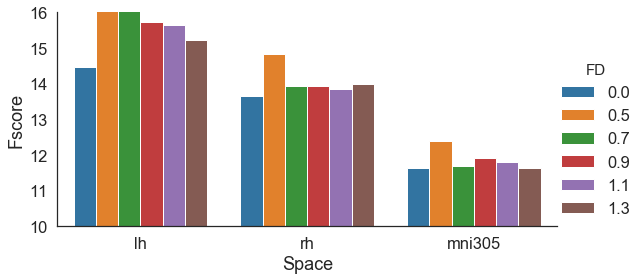

In [13]:
import os, shutil
import numpy as np
import nibabel as nib
import pylab as plt
import seaborn as sns
from pandas import DataFrame
from mne import read_surface, grow_labels, spatial_tris_connectivity, set_log_level
from mne.stats.cluster_level import _find_clusters as find_clusters
from scipy.stats import f_oneway
from scipy.stats import f as fdist
from scipy.ndimage import measurements
set_log_level(verbose=False)
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

version = 'Version20190405'
fs_dir = '/space/lilli/1/users/DARPA-Recons'
mri_dir = '/autofs/space/lilli_002/users/JNeurosci_ARC/fmri_first_levels/concat-sess/%s' % version

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O paramters.
sm = 6
contrast = 'Delib'
censor = True    # {True = Include blobs from all overlays, 
                 # False = Include blobs from only no-center}

## Cluster parameters.
cluster_dict = dict(lh = [0.01, 100], rh = [0.01, 100],
                    mni305 = [0.01, 20])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define iterators.
spaces = ['lh','rh','mni305']
thresholds = [0.0, 0.5, 0.7, 0.9, 1.1, 1.3]

info = []
for n, space in enumerate(spaces):
    #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Load data.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    #
    overlays = []
    for fd in thresholds: 
        obj = nib.load(os.path.join(mri_dir, '%s.%s.%s.%s' %(version, sm, fd, space), '%s.%s.par' % (version, contrast), 'F.nii.gz'))
        overlays.append( obj.get_data().squeeze() )
    overlays = np.array(overlays)
    #
    ## Make average map.
    if censor: average = overlays.mean(axis=0)
    else: average = overlays[0].copy()
    #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Identify clusters.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    p_value, min_cluster = cluster_dict[space]
    min_value = fdist.isf(p_value, 1, 26)
    #
    if space == 'mni305':
        #
        masked_average = average > min_value
        clusters, n_clusters = measurements.label( masked_average )
        clusters = [np.where(clusters==n) for n in np.arange(n_clusters)+1 if (clusters==n).sum() > min_cluster]
        #
    else:
        #
        ## Prepare surface information.
        _, tris = read_surface(os.path.join(fs_dir, 'fsaverage', 'surf', '%s.white' %space))
        connectivity = spatial_tris_connectivity(tris)
        include = np.invert(np.isnan(average).astype(bool))
        #
        ## Identify clusters (clusters already sorted by size).
        clusters, _ = find_clusters(average, min_value, tail=1, connectivity=connectivity, include=include)
        clusters = [c for c in clusters if len(c) > min_cluster]
    #
    print('%s clusters identified for %s.' %(len(clusters), space))
    #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Average across labels / spheres.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    #
    for i, fd in enumerate(thresholds):
        #
        for j, c in enumerate(clusters):
            #
            fscore = np.nanmean(overlays[i][c])
            info.append([fd,space,j,fscore])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
info = DataFrame(np.array(info), columns=('FD', 'Space', 'Label', 'Fscore'))
info['Fscore'] = info.Fscore.astype(float)
print(f_oneway(*[info.loc[info.FD==fd,'Fscore'].values for fd in np.unique(info.FD)]))
print(info.groupby(['FD',]).Fscore.mean())

## Plot.
g = sns.catplot('Space', 'Fscore', 'FD', info, kind='bar', ci=None, height=4, aspect=2);
g.ax.set_ylim(10,16);